In [1]:
from mtools import read_file, join_path
import pandas as pd
import os, sys
sys.path.append('..')
from tools.tools import convert_AllSenosr_log
from scipy.spatial.transform import Rotation as R
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# allsenorfile = '../IGRData/IGR230510/origin/Mate30_2/23.05.06-12_26_08.csv'
# h5file = '../IGRProcessed/Mate30_2/23_05_06_12_26_04/data.h5'

h5file = '../IGRProcessed/Mate30_2/23_05_06_12_36_43/data.h5'
rot_df = pd.read_csv('../IGRData/IGR230510/processed/Mate30_2/23_05_06_12_36_43/Rot.csv')
game_df = pd.read_csv('../IGRData/IGR230510/processed/Mate30_2/23_05_06_12_36_43/GameRot.csv')

store = pd.HDFStore(h5file, mode='r')
gngga_df = store.get('gngga')
acc_df = store.get('acc')
ori_deg_df = store.get('ori')
store.close()
gngga_df[['timestamp', 'elapsedRealtimeNanos']] = acc_df[['timestamp', 'elapsedRealtimeNanos']]

start_ela = np.max([gngga_df.iloc[0]['elapsedRealtimeNanos'], game_df.iloc[0]['elapsedRealtimeNanos'], rot_df.iloc[0]['elapsedRealtimeNanos'], ori_deg_df.iloc[0]['elapsedRealtimeNanos']])
end_ela = np.min([gngga_df.iloc[-1]['elapsedRealtimeNanos'], game_df.iloc[-1]['elapsedRealtimeNanos'], rot_df.iloc[-1]['elapsedRealtimeNanos'], ori_deg_df.iloc[-1]['elapsedRealtimeNanos']])

rot_df['elapsedRealtimeNanos'] = (rot_df['elapsedRealtimeNanos']-start_ela)/1e9
game_df['elapsedRealtimeNanos'] = (game_df['elapsedRealtimeNanos']-start_ela)/1e9
gngga_df['elapsedRealtimeNanos'] = (gngga_df['elapsedRealtimeNanos']-start_ela)/1e9
ori_deg_df['elapsedRealtimeNanos'] = (ori_deg_df['elapsedRealtimeNanos']-start_ela)/1e9
acc_df['elapsedRealtimeNanos'] = (acc_df['elapsedRealtimeNanos']-start_ela)/1e9
end_ela = (end_ela - start_ela)/1e9
start_ela = 0

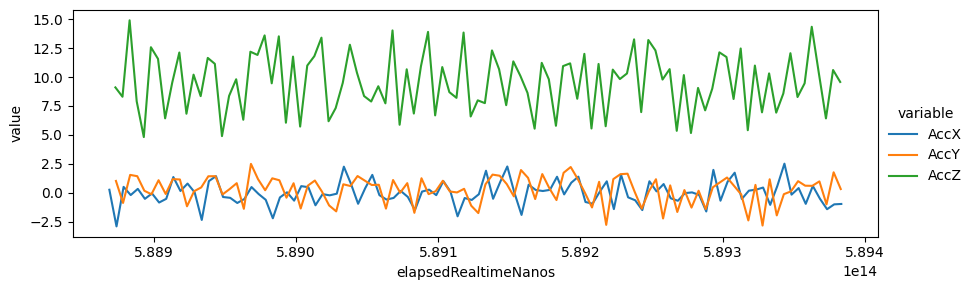

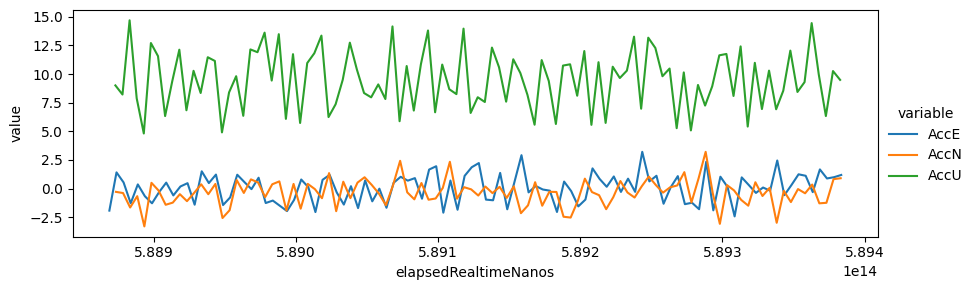

In [43]:
acc_melt_df = pd.melt(acc_df[['elapsedRealtimeNanos', 'AccX', 'AccY', 'AccZ']], id_vars=['elapsedRealtimeNanos'], value_vars=['AccX', 'AccY', 'AccZ'])
g = sns.FacetGrid(acc_melt_df[::500], hue='variable', despine=False, aspect=3)
g.map(sns.lineplot, "elapsedRealtimeNanos", "value")
g.add_legend()
plt.show()

rot = R.from_euler('xyz', ori_deg_df[['pitchDeg', 'rollDeg', 'yawDeg']], degrees=True)
acc_enu = rot.apply(acc_df[['AccX', 'AccY', 'AccZ']], inverse=True)
acc_df = acc_df.assign(AccE=acc_enu[:,0], AccN=acc_enu[:,1], AccU=acc_enu[:,2])

acc_enu_melt_df = pd.melt(acc_df[['elapsedRealtimeNanos', 'AccE', 'AccN', 'AccU']], id_vars=['elapsedRealtimeNanos'], value_vars=['AccE', 'AccN', 'AccU'])
g = sns.FacetGrid(acc_enu_melt_df[::500], hue='variable', despine=False, aspect=3)
g.map(sns.lineplot, "elapsedRealtimeNanos", "value")
g.add_legend()
plt.show()

In [44]:
print(acc_df.columns)
print(gngga_df.columns)
print(rot_df.columns)
print(game_df.columns)
print(ori_deg_df.columns)
print(start_ela, end_ela)

Index(['timestamp', 'elapsedRealtimeNanos', 'AccX', 'AccY', 'AccZ', 'Source',
       'AccE', 'AccN', 'AccU'],
      dtype='object')
Index(['timestamp', 'LatitudeDegrees', 'LongitudeDegrees', 'AltitudeMeters',
       'SatNum', 'Quality', 'hdop', 'PosE', 'PosN', 'PosU', 'Source',
       'elapsedRealtimeNanos'],
      dtype='object')
Index(['Rot', 'elapsedRealtimeNanos', 'utcTimeMillis', 'quaternionX',
       'quaternionY', 'quaternionZ', 'quaternionW'],
      dtype='object')
Index(['GameRot', 'elapsedRealtimeNanos', 'utcTimeMillis', 'quaternionX',
       'quaternionY', 'quaternionZ', 'quaternionW'],
      dtype='object')
Index(['timestamp', 'elapsedRealtimeNanos', 'yawDeg', 'rollDeg', 'pitchDeg',
       'Source'],
      dtype='object')
0 512.59401706275


In [46]:
from scipy import signal

def moving_average_filter(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

enu_pos = gngga_df[['PosE', 'PosN']].values
enu_pos[:, 0] = moving_average_filter(enu_pos[:, 0], 10)
enu_pos[:, 1] = moving_average_filter(enu_pos[:, 1], 10)
yaws = np.arctan2(enu_pos[1:, 1]-enu_pos[:-1, 1], enu_pos[1:, 0]-enu_pos[:-1, 0])*180/np.pi
gngga_df_new = gngga_df[1:]
gngga_df_new['yawDeg'] = yaws

euler = R.from_quat(rot_df[['quaternionX','quaternionY','quaternionZ','quaternionW']]).as_euler('xyz', degrees=True)
rot_df[['pitchDeg', 'rollDeg', 'yawDeg']] = euler
game_euler = R.from_quat(game_df[['quaternionX','quaternionY','quaternionZ','quaternionW']]).as_euler('xyz', degrees=True)
game_df[['pitchDeg', 'rollDeg', 'yawDeg']] = game_euler

/tmp/ipykernel_5883/3095051000.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gngga_df_new['yawDeg'] = yaws


In [47]:
def interpolate(df, start_ela, end_ela):
    desired_index = pd.RangeIndex(int(start_ela), int(end_ela), 1, name="elapsedRealtimeNanos")
    union_index = df.index.union(desired_index).dropna()
    df = df.reindex(union_index).interpolate('index')
    df = df.reindex(desired_index)
    return df

rot_df.set_index('elapsedRealtimeNanos', inplace=True)
game_df.set_index('elapsedRealtimeNanos', inplace=True)
gngga_df_new.set_index('elapsedRealtimeNanos', inplace=True)
ori_deg_df.set_index('elapsedRealtimeNanos', inplace=True)
acc_df.set_index('elapsedRealtimeNanos', inplace=True)
rot_df = interpolate(rot_df, start_ela, end_ela)
game_df = interpolate(game_df, start_ela, end_ela)
gngga_df_new = interpolate(gngga_df_new, start_ela, end_ela)
ori_deg_df = interpolate(ori_deg_df, start_ela, end_ela)
acc_df = interpolate(acc_df, start_ela, end_ela)
rot_df.reset_index(inplace=True)
game_df.reset_index(inplace=True)
gngga_df_new.reset_index(inplace=True)
ori_deg_df.reset_index(inplace=True)
acc_df.reset_index(inplace=True)

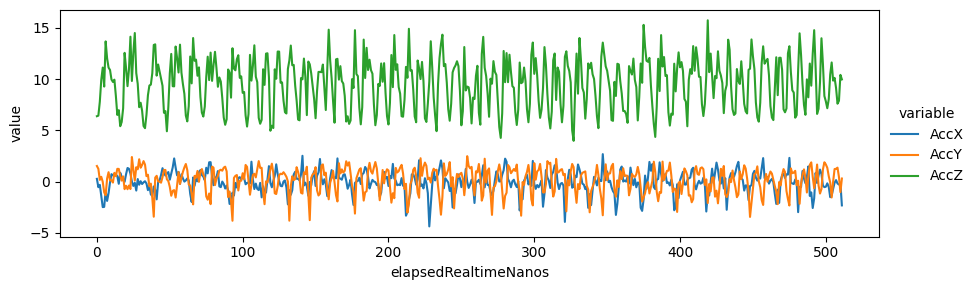

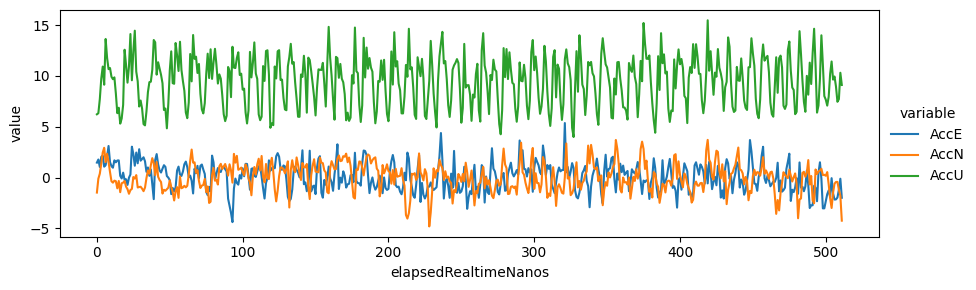

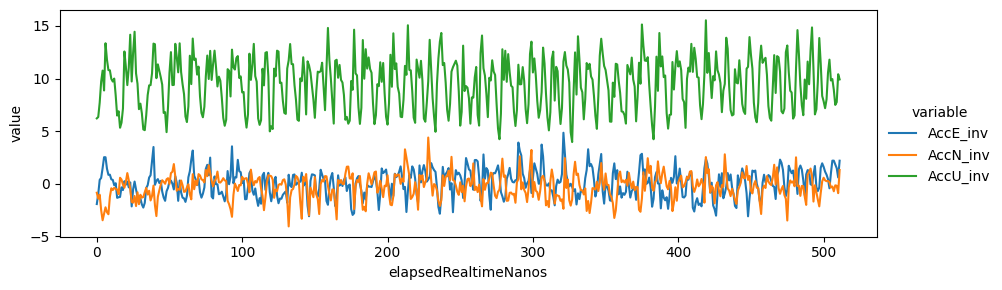

In [52]:
acc_melt_df = pd.melt(acc_df[['elapsedRealtimeNanos', 'AccX', 'AccY', 'AccZ']], id_vars=['elapsedRealtimeNanos'], value_vars=['AccX', 'AccY', 'AccZ'])
g = sns.FacetGrid(acc_melt_df, hue='variable', despine=False, aspect=3)
g.map(sns.lineplot, "elapsedRealtimeNanos", "value")
g.add_legend()
plt.show()

rot = R.from_euler('xyz', ori_deg_df[['pitchDeg', 'rollDeg', 'yawDeg']], degrees=True)
acc_enu_inv = rot.apply(acc_df[['AccX', 'AccY', 'AccZ']], inverse=True)
acc_df = acc_df.assign(AccE_inv=acc_enu[:,0], AccN_inv=acc_enu[:,1], AccU_inv=acc_enu[:,2])
acc_enu = rot.apply(acc_df[['AccX', 'AccY', 'AccZ']])
acc_df = acc_df.assign(AccE=acc_enu[:,0], AccN=acc_enu[:,1], AccU=acc_enu[:,2])

acc_enu_melt_df = pd.melt(acc_df[['elapsedRealtimeNanos', 'AccE', 'AccN', 'AccU']], id_vars=['elapsedRealtimeNanos'], value_vars=['AccE', 'AccN', 'AccU'])
g = sns.FacetGrid(acc_enu_melt_df, hue='variable', despine=False, aspect=3)
g.map(sns.lineplot, "elapsedRealtimeNanos", "value")
g.add_legend()
plt.show()

acc_enu_melt_df = pd.melt(acc_df[['elapsedRealtimeNanos', 'AccE_inv', 'AccN_inv', 'AccU_inv']], id_vars=['elapsedRealtimeNanos'], value_vars=['AccE_inv', 'AccN_inv', 'AccU_inv'])
g = sns.FacetGrid(acc_enu_melt_df, hue='variable', despine=False, aspect=3)
g.map(sns.lineplot, "elapsedRealtimeNanos", "value")
g.add_legend()
plt.show()

# game_rot = R.from_euler('xyz', game_df[['pitchDeg', 'rollDeg', 'yawDeg']], degrees=True)
# acc_game = rot.apply(acc_df[['AccX', 'AccY', 'AccZ']], inverse=True)
# acc_df = acc_df.assign(AccE=acc_enu[:,0], AccN=acc_enu[:,1], AccU=acc_enu[:,2])

# acc_enu_melt_df = pd.melt(acc_df[['elapsedRealtimeNanos', 'AccE', 'AccN', 'AccU']], id_vars=['elapsedRealtimeNanos'], value_vars=['AccE', 'AccN', 'AccU'])
# g = sns.FacetGrid(acc_enu_melt_df[::500], hue='variable', despine=False, aspect=3)
# g.map(sns.lineplot, "elapsedRealtimeNanos", "value")
# g.add_legend()
# plt.show()

512 512


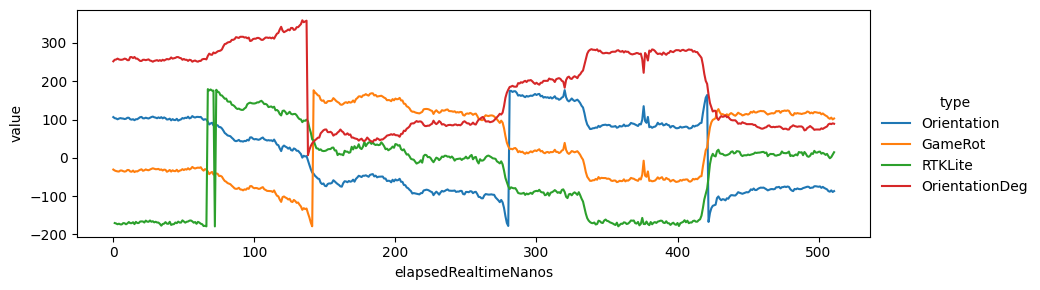

In [9]:
print(len(rot_df), len(game_df))
rot_df['type'] = 'Orientation'
game_df['type'] = 'GameRot'
gngga_df_new['type'] = 'RTKLite'
ori_deg_df['type'] = 'OrientationDeg'

rot_melt_df = pd.melt(rot_df[['elapsedRealtimeNanos', 'type', 'yawDeg']], id_vars=['elapsedRealtimeNanos', 'type'], value_vars=['yawDeg'])
game_melt_df = pd.melt(game_df[['elapsedRealtimeNanos', 'type', 'yawDeg']], id_vars=['elapsedRealtimeNanos', 'type'], value_vars=['yawDeg'])
gngga_melt_df = pd.melt(gngga_df_new[['elapsedRealtimeNanos', 'type', 'yawDeg']], id_vars=['elapsedRealtimeNanos', 'type'], value_vars=['yawDeg'])
ori_deg_melt_df = pd.melt(ori_deg_df[['elapsedRealtimeNanos', 'type', 'yawDeg']], id_vars=['elapsedRealtimeNanos', 'type'], value_vars=['yawDeg'])
# gngga_melt_df['elapsedRealtimeNanos'] = gngga_melt_df['elapsedRealtimeNanos']+15
# gngga_melt_df.loc[gngga_melt_df['value']>0, 'value'] = - 360 + gngga_melt_df[gngga_melt_df['value']>0]['value']
df = pd.concat((rot_melt_df, game_melt_df, gngga_melt_df, ori_deg_melt_df))
df.columns

g = sns.FacetGrid(df, hue='type', despine=False, aspect=3)
g.map(sns.lineplot, "elapsedRealtimeNanos", "value")
g.add_legend()
plt.show()

In [173]:
from scipy import signal

def moving_average_filter(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

diff_df = pd.DataFrame(rot_df[['elapsedRealtimeNanos']])
diff_df['yawDeg'] = rot_df['yawDeg'] - game_df['yawDeg']
diff_df.loc[diff_df['yawDeg']<-180, 'yawDeg'] = 360 + diff_df[diff_df['yawDeg']<-180]['yawDeg']
diff_df.loc[diff_df['yawDeg']>180, 'yawDeg'] = 360 + diff_df[diff_df['yawDeg']>180]['yawDeg']
diff_df['yawDeg'] = diff_df['yawDeg'] - np.mean(diff_df['yawDeg'])
# diff_df['filtered'] = moving_average_filter(diff_df['yawDeg'], 5)
# diff_melt_df = pd.melt(diff_df[['elapsedRealtimeNanos', 'yawDeg', 'filtered']], id_vars=['elapsedRealtimeNanos'], value_vars=['yawDeg', 'filtered'])
# sns.lineplot(diff_df, x='elapsedRealtimeNanos', y='yawDeg'); plt.show() # , hue='variable'

rot_game_diff = diff_df.copy()

diff_df = pd.DataFrame(rot_df[['elapsedRealtimeNanos']])
diff_df['yawDeg'] = gngga_df_new['yawDeg'] - game_df['yawDeg']
diff_df.loc[diff_df['yawDeg']<-180, 'yawDeg'] = 360 + diff_df[diff_df['yawDeg']<-180]['yawDeg']
diff_df.loc[diff_df['yawDeg']>180, 'yawDeg'] = - 360 + diff_df[diff_df['yawDeg']>180]['yawDeg']

# diff_df.loc[diff_df['yawDeg']<0, 'yawDeg'] = 360 + diff_df[diff_df['yawDeg']<0]['yawDeg']
diff_df['yawDeg'] = diff_df['yawDeg'] - np.mean(diff_df['yawDeg'])
# diff_df['filtered'] = moving_average_filter(diff_df['yawDeg'], 5)
# diff_melt_df = pd.melt(diff_df[['elapsedRealtimeNanos', 'yawDeg', 'filtered']], id_vars=['elapsedRealtimeNanos'], value_vars=['yawDeg', 'filtered'])
# g = sns.lineplot(diff_df, x='elapsedRealtimeNanos', y='yawDeg')
# g.set(ylim=[-50, 50])
# plt.show()

gt_game_diff = diff_df.copy()

diff_df = pd.DataFrame(rot_df[['elapsedRealtimeNanos']])
diff_df['yawDeg'] = gngga_df_new['yawDeg'] - rot_df['yawDeg']
diff_df.loc[diff_df['yawDeg']<-180, 'yawDeg'] = 360 + diff_df[diff_df['yawDeg']<-180]['yawDeg']
diff_df.loc[diff_df['yawDeg']>180, 'yawDeg'] = - 360 + diff_df[diff_df['yawDeg']>180]['yawDeg']
diff_df['yawDeg'] = diff_df['yawDeg'] - np.mean(diff_df['yawDeg'])
# diff_df['filtered'] = moving_average_filter(diff_df['yawDeg'], 5)
# diff_melt_df = pd.melt(diff_df[['elapsedRealtimeNanos', 'yawDeg', 'filtered']], id_vars=['elapsedRealtimeNanos'], value_vars=['yawDeg', 'filtered'])
# g = sns.lineplot(diff_df, x='elapsedRealtimeNanos', y='yawDeg')
# g.set(ylim=[-50, 50])
# plt.show()

gt_rot_diff = diff_df.copy()

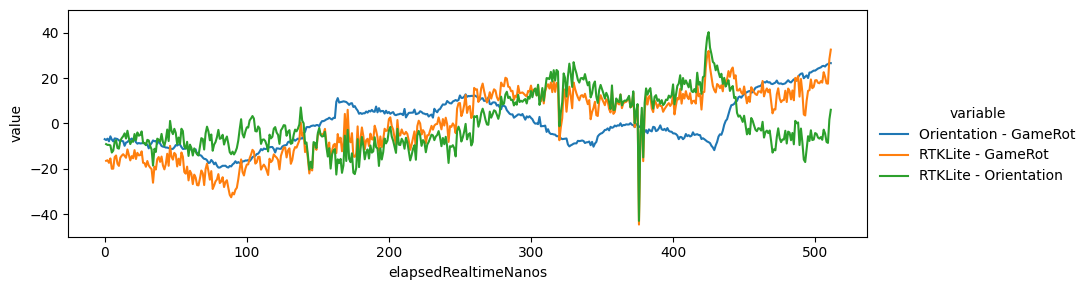

In [172]:
diff_df = pd.concat((rot_game_diff.rename(columns={"yawDeg": "Orientation - GameRot"}), gt_game_diff['yawDeg'].rename("RTKLite - GameRot"), gt_rot_diff['yawDeg'].rename("RTKLite - Orientation")), axis=1)
diff_melt_df = pd.melt(diff_df[['elapsedRealtimeNanos', 'Orientation - GameRot', 'RTKLite - GameRot', 'RTKLite - Orientation']], id_vars=['elapsedRealtimeNanos'], value_vars=['Orientation - GameRot', 'RTKLite - GameRot', 'RTKLite - Orientation'])
# g = sns.lineplot(diff_melt_df, x='elapsedRealtimeNanos', y='value', hue='variable')
g = sns.FacetGrid(diff_melt_df, hue='variable', despine=False, aspect=3)
g.map(sns.lineplot, "elapsedRealtimeNanos", "value")
g.add_legend()
g.set(ylim=[-50, 50])
plt.show()

In [ ]:
game_df_delta = pd.DataFrame(rot_df[['elapsedRealtimeNanos']])
game_df_delta['yawDeg'] = game_df['yawDeg'] + moving_average_filter(gt_game_diff['yawDeg'].values, 30)

rot_df_delta = pd.DataFrame(rot_df[['elapsedRealtimeNanos']])
rot_df_delta['yawDeg'] = rot_df['yawDeg'] + moving_average_filter(gt_rot_diff['yawDeg'].values, 30)

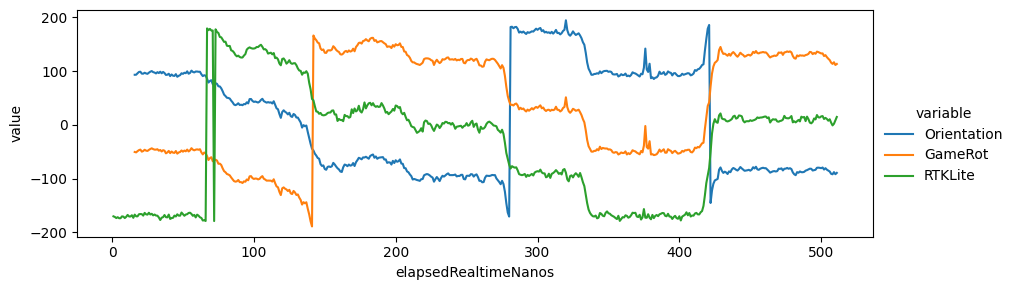

In [184]:
game_df_fix = pd.DataFrame(rot_df[['elapsedRealtimeNanos']])
game_df_fix['yawDeg'] = game_df['yawDeg'] + moving_average_filter(gt_game_diff['yawDeg'].values, 30)

rot_df_fix = pd.DataFrame(rot_df[['elapsedRealtimeNanos']])
rot_df_fix['yawDeg'] = rot_df['yawDeg'] + moving_average_filter(gt_rot_diff['yawDeg'].values, 30)

diff_df = pd.concat((game_df_fix.rename(columns={"yawDeg": "GameRot"}), rot_df_fix['yawDeg'].rename("Orientation"), gngga_df_new['yawDeg'].rename("RTKLite")), axis=1)
diff_melt_df = pd.melt(diff_df[['elapsedRealtimeNanos', 'Orientation', 'GameRot', 'RTKLite']], id_vars=['elapsedRealtimeNanos'], value_vars=['Orientation', 'GameRot', 'RTKLite'])
g = sns.FacetGrid(diff_melt_df, hue='variable', despine=False, aspect=3)
g.map(sns.lineplot, "elapsedRealtimeNanos", "value")
g.add_legend()
plt.show()

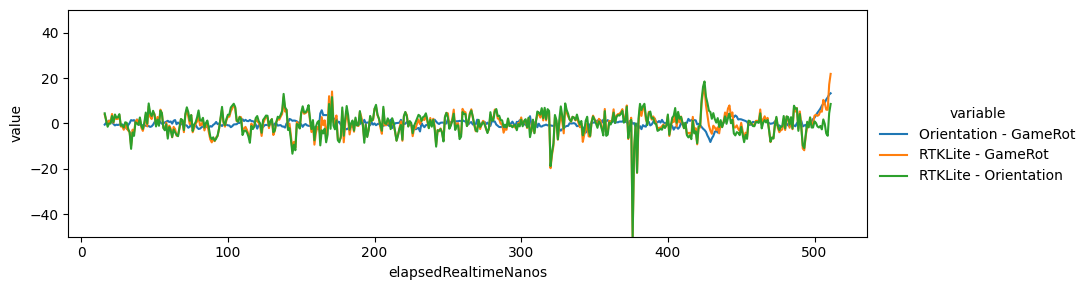

In [185]:
rot_df = rot_df_fix
game_df = game_df_fix
diff_df = pd.DataFrame(rot_df[['elapsedRealtimeNanos']])
diff_df['yawDeg'] = rot_df['yawDeg'] - game_df['yawDeg']
diff_df.loc[diff_df['yawDeg']<-180, 'yawDeg'] = 360 + diff_df[diff_df['yawDeg']<-180]['yawDeg']
diff_df.loc[diff_df['yawDeg']>180, 'yawDeg'] = 360 + diff_df[diff_df['yawDeg']>180]['yawDeg']
diff_df['yawDeg'] = diff_df['yawDeg'] - np.mean(diff_df['yawDeg'])
# diff_df['filtered'] = moving_average_filter(diff_df['yawDeg'], 5)
# diff_melt_df = pd.melt(diff_df[['elapsedRealtimeNanos', 'yawDeg', 'filtered']], id_vars=['elapsedRealtimeNanos'], value_vars=['yawDeg', 'filtered'])
# sns.lineplot(diff_df, x='elapsedRealtimeNanos', y='yawDeg'); plt.show() # , hue='variable'

rot_game_diff = diff_df.copy()

diff_df = pd.DataFrame(rot_df[['elapsedRealtimeNanos']])
diff_df['yawDeg'] = gngga_df_new['yawDeg'] - game_df['yawDeg']
diff_df.loc[diff_df['yawDeg']<-180, 'yawDeg'] = 360 + diff_df[diff_df['yawDeg']<-180]['yawDeg']
diff_df.loc[diff_df['yawDeg']>180, 'yawDeg'] = - 360 + diff_df[diff_df['yawDeg']>180]['yawDeg']

# diff_df.loc[diff_df['yawDeg']<0, 'yawDeg'] = 360 + diff_df[diff_df['yawDeg']<0]['yawDeg']
diff_df['yawDeg'] = diff_df['yawDeg'] - np.mean(diff_df['yawDeg'])
# diff_df['filtered'] = moving_average_filter(diff_df['yawDeg'], 5)
# diff_melt_df = pd.melt(diff_df[['elapsedRealtimeNanos', 'yawDeg', 'filtered']], id_vars=['elapsedRealtimeNanos'], value_vars=['yawDeg', 'filtered'])
# g = sns.lineplot(diff_df, x='elapsedRealtimeNanos', y='yawDeg')
# g.set(ylim=[-50, 50])
# plt.show()

gt_game_diff = diff_df.copy()

diff_df = pd.DataFrame(rot_df[['elapsedRealtimeNanos']])
diff_df['yawDeg'] = gngga_df_new['yawDeg'] - rot_df['yawDeg']
diff_df.loc[diff_df['yawDeg']<-180, 'yawDeg'] = 360 + diff_df[diff_df['yawDeg']<-180]['yawDeg']
diff_df.loc[diff_df['yawDeg']>180, 'yawDeg'] = - 360 + diff_df[diff_df['yawDeg']>180]['yawDeg']
diff_df['yawDeg'] = diff_df['yawDeg'] - np.mean(diff_df['yawDeg'])
# diff_df['filtered'] = moving_average_filter(diff_df['yawDeg'], 5)
# diff_melt_df = pd.melt(diff_df[['elapsedRealtimeNanos', 'yawDeg', 'filtered']], id_vars=['elapsedRealtimeNanos'], value_vars=['yawDeg', 'filtered'])
# g = sns.lineplot(diff_df, x='elapsedRealtimeNanos', y='yawDeg')
# g.set(ylim=[-50, 50])
# plt.show()

gt_rot_diff = diff_df.copy()

diff_df = pd.concat((rot_game_diff.rename(columns={"yawDeg": "Orientation - GameRot"}), gt_game_diff['yawDeg'].rename("RTKLite - GameRot"), gt_rot_diff['yawDeg'].rename("RTKLite - Orientation")), axis=1)
diff_melt_df = pd.melt(diff_df[['elapsedRealtimeNanos', 'Orientation - GameRot', 'RTKLite - GameRot', 'RTKLite - Orientation']], id_vars=['elapsedRealtimeNanos'], value_vars=['Orientation - GameRot', 'RTKLite - GameRot', 'RTKLite - Orientation'])
# g = sns.lineplot(diff_melt_df, x='elapsedRealtimeNanos', y='value', hue='variable')
g = sns.FacetGrid(diff_melt_df, hue='variable', despine=False, aspect=3)
g.map(sns.lineplot, "elapsedRealtimeNanos", "value")
g.add_legend()
g.set(ylim=[-50, 50])
plt.show()